In [2]:
%load_ext autoreload
%autoreload 2

import numpy as np
import scipy as sp
import pandas as pd
from os import listdir
from os.path import isfile, join
import pymc3 as pm
import math as m
import arviz as az

import dive
import matplotlib.pyplot as plt
import deerlab as dl

from theano import tensor as T
from theano.tensor import nlinalg as tnp
from theano.tensor import slinalg as snp

### Generate a synthetic distribution and calculate S

In [3]:
data, pars = dive.generateMultiGauss(nt = 160, seed = 129, k = 0.5, sigma = 0.01, V0 = 1.15, t_edges=[-0.1,3.0])

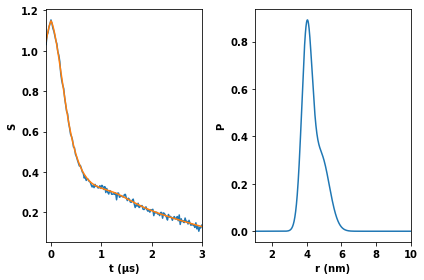

In [4]:
t = data['t']
Vexp = data['V']

fig, ax = plt.subplots(1,2)
line0 = ax[0].plot(t, Vexp)
line1 = ax[0].plot(t, data['V0'])
line2 = ax[1].plot(data['r'], data['P'])

ax[0].set(xlim = [min(t),max(t)], xlabel = 't (µs)', ylabel = 'S')
ax[1].set(xlim = [min(data['r']),max(data['r'])], xlabel = 'r (nm)', ylabel = 'P')
plt.tight_layout()
plt.show()

### Initialize parameters and matrices

In [5]:
# r vector
r = np.linspace(2,8,150)
dr = r[1] - r[0]

# kernel regularization operator
K0 = dl.dipolarkernel(t,r,integralop=False)   # kernel matrix
L = dl.regoperator(np.linspace(1,len(r),len(r)), 2)
LtL = np.matmul(np.transpose(L),L)
K0tK0 = np.matmul(np.transpose(K0),K0)

# parameters for delta distribution
a0 = 0.01
b0 = 1e-6

### Setup model

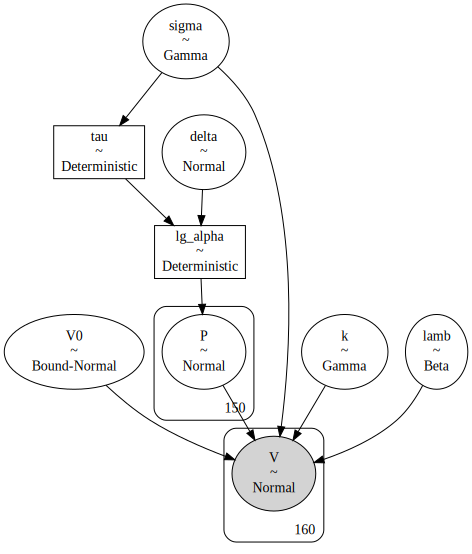

In [6]:
with pm.Model() as model:
    # Noise --------------------------------------------------------------
    sigma = pm.Gamma('sigma', alpha=0.7, beta=2)
    tau = pm.Deterministic('tau',1/(sigma**2))

    # Regularization parameter -------------------------------------------
    delta = pm.Normal('delta', mu = 20000, sigma = 10000)
    lg_alpha = pm.Deterministic('lg_alpha', np.log10(np.sqrt(delta/tau)) )
    
    # Time Domain --------------------------------------------------------
    lamb = pm.Beta('lamb', alpha=1.3, beta=2.0)
    V0 = pm.Bound(pm.Normal, lower=0.0)('V0', mu=1, sigma=0.2)

    # Background ---------------------------------------------------------
    k = pm.Gamma('k', alpha=0.5, beta=2)
    B = dl.bg_exp(t, k)

    # Distance distribution ----------------------------------------------
    # P = pm.MvNormal("P", mu = np.ones_like(r), tau = invSigma, shape = len(r))
    P = pm.Normal("P", mu = 1, sigma = lg_alpha, shape = len(r))      

    # Calculate matrices and operators -----------------------------------
    Kintra = (1-lamb) + lamb*K0
    B_ = T.transpose( T.tile(B,(len(r),1)) )
    K = V0*Kintra*B_*dr

    # Time domain model ---------------------------------------------------
    Vmodel = pm.math.dot(K,P)

    # Likelihood ----------------------------------------------------------
    pm.Normal('V',mu = Vmodel, sigma = sigma, observed = Vexp)

pm.model_to_graphviz(model) 

### Run sampler

In [21]:
from pymc3.step_methods.arraystep import BlockedStep
import pymc3 as pm
import scipy as sp
from pymc3.distributions.transforms import log

class SamplePfromV_print(BlockedStep):
    def __init__(self, var, K0, LtL, t, V, r, delta, sigma, k, lamb, V0):
            self.vars = [var]
            self.var = var
            
            # precalculated values
            self.K0 = K0
            self.LtL = LtL
            self.V = V
            self.r = r
            self.t = t

            # random variables
            self.delta = delta
            self.sigma = sigma
            self.k = k
            self.lamb = lamb
            self.V0 = V0    

    def step(self, point: dict):
        print('Step P    : k: ' + str(np.exp(point['k_log__'])) + ' V0 ' + str(np.exp(point['V0_lowerbound__'])) + ' l ' + str(sp.special.expit(point['lamb_logodds__'])) + ' s ' + str(np.exp(point['sigma_log__'])) + ' d ' + str(point['delta']) + ' P[0] ' + str(point['P'][0]))
        # transform parameters
        sigma = dive.undo_transform(point,self.sigma.transformed.name)
        # delta = undo_transform(point,self.delta.transformed.name)
        delta = dive.undo_transform(point,self.delta.name)
        k = dive.undo_transform(point,self.k.transformed.name)
        lamb = dive.undo_transform(point,self.lamb.transformed.name)
        V0 = dive.undo_transform(point,self.V0.transformed.name)        

        # calculate some values
        tau = 1/(sigma**2)
        dr = self.r[1] - self.r[0]

        # Background
        B = dl.bg_exp(self.t,k) 

        # Kernel
        Kintra = (1-lamb)+lamb*self.K0
        K = Kintra * B[:, np.newaxis]
        K = V0*K*dr

        # KtXs
        KtK = np.matmul(np.transpose(K),K)
        KtV = np.matmul(np.transpose(K),self.V) 

        tauKtV = tau*KtV
        invSigma = tau*KtK + delta*self.LtL
        
        newpoint = point.copy()
        Pdraw = dive.randP(tauKtV,invSigma)
        Pdraw =  Pdraw / np.sum(Pdraw) / dr
        newpoint[self.var.name] = Pdraw

        return newpoint

class randDelta_print(BlockedStep):
    def __init__(self, var, a0, b0, L, P):
            self.vars = [var]
            self.var = var
            self.P = P
            self.a0 = a0
            self.b0 = b0
            self.L = L

    def step(self, point: dict):
        print('Step delta: k: ' + str(np.exp(point['k_log__'])) + ' V0 ' + str(np.exp(point['V0_lowerbound__'])) + ' l ' + str(sp.special.expit(point['lamb_logodds__'])) + ' s ' + str(np.exp(point['sigma_log__'])) + ' d ' + str(point['delta']) + ' P[0] ' + str(point['P'][0]))
        P = point[self.P.name]

        n_p = sum(np.asarray(P)>0)
        a_ = self.a0 + n_p/2
        b_ = self.b0 + (1/2)*np.linalg.norm(self.L@P)**2

        newpoint = point.copy()
        delta_draw =  np.random.gamma(a_, 1/b_, 1)[0]
        newpoint[self.var.name] = delta_draw

        return newpoint

In [22]:
point = model.test_point
print('Initial values: k: ' + str(np.exp(point['k_log__'])) + ' V0 ' + str(np.exp(point['V0_lowerbound__'])) + ' l ' + str(sp.special.expit(point['lamb_logodds__'])) + ' s ' + str(np.exp(point['sigma_log__'])) + ' d ' + str(point['delta']) + ' P[0] ' + str(point['P'][0]))

Initial values: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 20000.0 P[0] 1.0


In [24]:
with model:
    step_P = SamplePfromV_print(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = randDelta_print(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_P, step_delta], chains=1, cores=1, draws=20, tune= 10, return_inferencedata=False, progressbar = False)

Only 20 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>SamplePfromV_print: [P]
>randDelta_print: [delta]
>NUTS: [k, V0, lamb, sigma]
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 20000.0 P[0] 1.0
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 20000.0 P[0] 0.0023015732443038327
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 14807.78878241502 P[0] 0.0023015732443038327
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 14807.78878241502 P[0] 0.011927641282282955
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 12024.774524566968 P[0] 0.011927641282282955
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 12024.774524566968 P[0] 0.0
Step P    : k: 0.2679374696698308 V0 1.0054854559856263 l 0.396976005587851 s 0.31801980350690723 d 11743.121796658674 P[0] 0.0
Step delta: k: 0.2679374696698308 V0 1.0054854559856263 l 0.396976005587851 s 0.

In [25]:
with model:
    step_P = SamplePfromV_print(P, K0, LtL, t, Vexp, r, delta, sigma, k, lamb, V0)
    step_delta = randDelta_print(delta, a0, b0, L, P)
    trace = pm.sample(step = [step_delta, step_P], chains=1, cores=1, draws=10, tune= 10, return_inferencedata=False, progressbar = False)

Only 10 samples in chain.
Sequential sampling (1 chains in 1 job)
CompoundStep
>randDelta_print: [delta]
>SamplePfromV_print: [P]
>NUTS: [k, V0, lamb, sigma]
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 20000.0 P[0] 1.0
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 66.25939195821665 P[0] 1.0
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 66.25939195821665 P[0] 0.02058538757435892
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 43.65961340141985 P[0] 0.02058538757435892
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 43.65961340141985 P[0] 0.01168376839389441
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 26.28697474653951 P[0] 0.01168376839389441
Step delta: k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 26.28697474653951 P[0] 0.0
Step P    : k: 0.25 V0 1.0 l 0.393939393939394 s 0.3499999999999999 d 23.780728848116233 P[0] 0.0
Step delta: